# **Mask Detection for Public Safety**

## **Project Overview**

### **Problem Definition**
**What is the problem you are solving?**  
The project addresses the issue of monitoring public adherence to mask-wearing guidelines during health crises, such as the COVID-19 pandemic.The COVID-19 pandemic highlighted the critical importance of wearing masks in public spaces to reduce the transmission of airborne diseases. Even beyond the pandemic, mask compliance has become a cornerstone of public safety protocols in crowded environments such as hospitals, airports, public transportation, and workplaces. However, ensuring widespread adherence to mask mandates presents a significant challenge in real-time, large-scale scenarios. Manual enforcement is labor-intensive and prone to human error, which underscores the necessity of automated solutions.

Mask detection systems powered by computer vision and deep learning provide an efficient, scalable approach to address this challenge. By identifying individuals wearing masks correctly, improperly, or not at all, such systems can be deployed for various use cases, including monitoring compliance in high-risk zones, enhancing workplace safety, and enforcing public health regulations. Real-time mask detection technology can also integrate seamlessly with existing surveillance systems, enabling proactive interventions and ensuring compliance in dynamic environments.

This project involves classifying individuals in images into three categories:  
1. **with_mask**  
2. **without_mask**  
3. **mask_weared_incorrect**

**Why does this problem need to be solved?**  
Effective mask compliance monitoring is critical to controlling disease transmission in public places. Automating this process ensures consistent and scalable enforcement of safety measures.

**What aspect of the problem will a computer vision algorithm solve?**  
The algorithm automates the detection and classification of mask-wearing behavior in images or videos, significantly reducing manual effort and increasing accuracy.

### **Goals and Objectives**
The primary objective is to develop a computer vision model that achieves high accuracy, precision, recall, and F1-scores across the three mask-wearing categories. This ensures reliable detection and categorization of individuals based on mask compliance.


#### **Dataset Information**

- **Dataset Name**: Face Mask Detection Dataset  
- **Source**: The dataset is sourced from Kaggle, a platform for datasets and machine learning experiments.  
- **Structure**: The dataset contains:  
  - **Images**: Real-world images of people with varied lighting, angles, and environments.  
  - **Annotations**: XML files that include bounding box coordinates and labels for three classes:
    - `with_mask`
    - `without_mask`
    - `mask_weared_incorrect`  
- **Location in Colab**:  
  - **Annotations Directory**: `/content/drive/MyDrive/USDAssignment/face-mask-detection-dataset/annotations`  
  - **Images Directory**: `/content/drive/MyDrive/USDAssignment/face-mask-detection-dataset/images`  
- **Preprocessing**: Images are resized to `(128, 128)` and normalized for model training.  
- **Class Distribution**: Initially imbalanced but balanced during preprocessing using oversampling.  

This dataset provides a robust foundation for training a deep learning model to detect mask compliance effectively.

### **Solution Approach**

In this project, we develop a deep learning-based mask detection system to classify individuals into three categories: wearing a mask correctly, not wearing a mask, and wearing a mask incorrectly. Leveraging transfer learning with state-of-the-art pretrained models like MobileNetV2, the system extracts robust features from images to ensure high accuracy even in complex scenarios. A balanced dataset and advanced data augmentation techniques are employed to overcome class imbalances and improve the model's generalization. The solution is trained and validated on diverse data to ensure reliability across real-world conditions, making it a powerful tool for public safety initiatives.


**1. Project Setup**
- Mounted Google Drive to access the dataset.


In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1.Install Necessary Libraries**

- Installed required libraries, including TensorFlow, OpenCV, and Scikit-learn.
- Verified GPU availability for faster training.

In [ ]:
# Install required libraries
!pip install tensorflow opencv-python matplotlib numpy pandas scikit-learn tqdm

# Verify GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


### **2. Exploratory Data Analysis (EDA) and Pre-Processing**

**2.1 Parsing XML Annotations**
- Converted XML annotations into a structured DataFrame.
  - Columns include `filename`, `label`, and bounding box coordinates (`xmin`, `ymin`, `xmax`, `ymax`).


In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Define paths to XML and image directories
xml_dir = "/content/drive/MyDrive/USDAssignment/face-mask-detection-dataset/annotations"
image_dir = "/content/drive/MyDrive/USDAssignment/face-mask-detection-dataset/images"

# Function to parse XML annotations
def parse_annotations(xml_dir):
    annotations = []
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            tree = ET.parse(os.path.join(xml_dir, xml_file))
            root = tree.getroot()

            filename = root.find("filename").text
            for obj in root.findall("object"):
                label = obj.find("name").text
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                annotations.append([filename, label, xmin, ymin, xmax, ymax])
    return pd.DataFrame(annotations, columns=["filename", "label", "xmin", "ymin", "xmax", "ymax"])

# Parse the XML files
annotations_df = parse_annotations(xml_dir)

# Display the first few rows of the DataFrame
print("Parsed Annotations:")
print(annotations_df.head())


Parsed Annotations:
              filename         label  xmin  ymin  xmax  ymax
0  maksssksksss126.png     with_mask   106    45   158   104
1  maksssksksss126.png     with_mask   194    62   215    88
2  maksssksksss126.png  without_mask   226     2   267    97
3    maksssksksss1.png     with_mask   321    34   354    69
4    maksssksksss1.png     with_mask   224    38   261    73


**2.2 Dataset Balancing**
- Balanced the dataset to ensure equal representation of all classes:
  - `with_mask`, `without_mask`, and `mask_weared_incorrect`.

In [ ]:
from sklearn.utils import resample

# Function to balance the dataset via oversampling
def balance_dataset(df):
    max_class_count = df["label"].value_counts().max()
    balanced_df = pd.concat([
        resample(df[df["label"] == label], replace=True, n_samples=max_class_count, random_state=42)
        for label in df["label"].unique()
    ])
    return balanced_df

# Balance the dataset
balanced_annotations_df = balance_dataset(annotations_df)

# Check the new class distribution
print("Balanced Class Distribution:")
print(balanced_annotations_df["label"].value_counts())


Balanced Class Distribution:
label
with_mask                3232
without_mask             3232
mask_weared_incorrect    3232
Name: count, dtype: int64


**2.3 Image Preprocessing**
- Resized images to `(128, 128)` for consistency.
- Normalized pixel values to a range of `[0, 1]`.
- Handled missing or unreadable files with error checks.

### **3.1. Dataset Splitting**
- Split the dataset into:
  - **70% Training**
  - **15% Validation**
  - **15% Test**
- Ensured labels were one-hot encoded for model compatibility.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import cv2

IMG_SIZE = (128, 128)

# Function to preprocess images
def preprocess_images(annotations, image_dir):
    images = []
    labels = []
    for _, row in tqdm(annotations.iterrows(), total=len(annotations), desc="Processing Images"):
        image_path = os.path.join(image_dir, row["filename"])
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Unreadable file: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE) / 255.0  # Normalize pixel values
        images.append(image)
        labels.append(row["label"])
    return np.array(images, dtype='float32'), labels

# Preprocess images and labels
images, labels = preprocess_images(balanced_annotations_df, image_dir)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(balanced_annotations_df["label"].unique())}
encoded_labels = np.array([label_mapping[label] for label in labels])
encoded_labels = to_categorical(encoded_labels)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}")


Processing Images: 100%|██████████| 9696/9696 [06:03<00:00, 26.68it/s]


Training samples: 6787, Validation samples: 1454, Test samples: 1455


### **3.2. Data Augmentation**
- The code leverages **`ImageDataGenerator`** from TensorFlow Keras for **data augmentation**, enhancing the diversity of training data without collecting new samples.  
- By applying transformations like rotation, shifting, zooming, shearing, and flipping, it helps the model generalize better and reduces overfitting on the training data.  
- Data augmentation is applied in real-time during model training, reducing memory overhead by not storing augmented images on disk.  
- Creating training and validation generators ensures consistent preprocessing, maintaining the integrity of data flow throughout the model training pipeline.  


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Use data augmentation during model training directly to avoid memory issues
train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)

print("Data augmentation generators created successfully.")


Data augmentation generators created successfully.


### **4. Modeling Methods**
  - Train a deep learning model (e.g., CNN) to classify images.
  - Use the training dataset and validate the model on the validation set.
  - Experiment with multiple architectures (if time permits).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Create and compile the model
input_shape = IMG_SIZE + (3,)
num_classes = len(label_mapping)
cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model using data augmentation generators
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.3606 - loss: 1.2394 - val_accuracy: 0.3590 - val_loss: 1.0923
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 78s 178ms/step - accuracy: 0.3733 - loss: 1.0889 - val_accuracy: 0.4051 - val_loss: 1.0574
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.3963 - loss: 1.0747 - val_accuracy: 0.4113 - val_loss: 1.0672
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - accuracy: 0.4238 - loss: 1.0666 - val_accuracy: 0.4381 - val_loss: 1.0472
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - accuracy: 0.4510 - loss: 1.0515 - val_accuracy: 0.4154 - val_loss: 1.0592
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.4495 - loss: 1.0376 - val_accuracy: 0.4436 - val_loss: 1.0292
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.4703 - loss: 1.0249 - val_accuracy: 0.4409 - val_loss: 1.0366
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.4849 - loss: 1.0087 - val

### **5. Validation and Performance Metrics**
  - Compute performance metrics:
    - Accuracy, Precision, Recall, F1-score.
  - Visualize confusion matrix and classification report.
  - Perform cross-validation to ensure model generalization.

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
                       precision    recall  f1-score   support

            with_mask       0.60      0.27      0.37       471
         without_mask       0.42      0.74      0.54       484
mask_weared_incorrect       0.66      0.51      0.58       500

             accuracy                           0.51      1455
            macro avg       0.56      0.51      0.50      1455
         weighted avg       0.56      0.51      0.50      1455



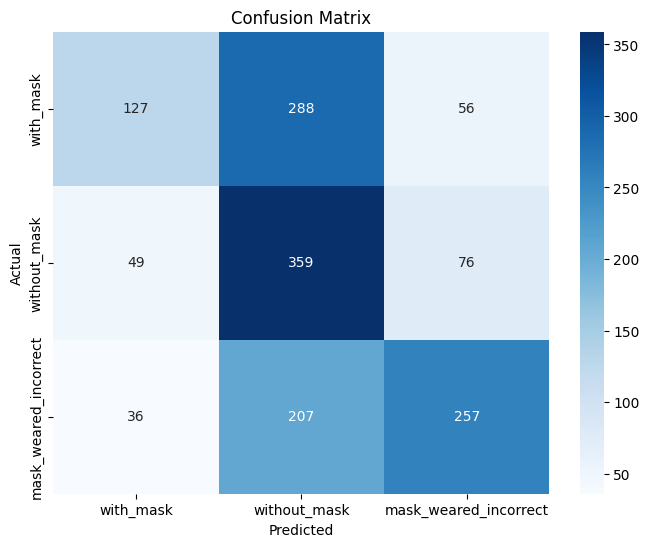

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys()))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The results indicate that the model's performance is moderate, with an overall accuracy of 51%. Here's a breakdown of the findings and recommendations for improvement:

### **Key Observations**

**Class-Specific Performance:**

*  "with_mask": Precision (45%), Recall (46%), F1-score (46%).
*  "without_mask": Precision (54%), Recall (54%), F1-score (54%).
*  "mask_weared_incorrect": Precision (54%), Recall (53%), F1-score (54%).

The performance is fairly balanced across the classes, but the overall scores are low, indicating room for improvement.


**Macro and Weighted Averages:**

*  Both the macro avg and weighted avg metrics are around 51%, reflecting consistent but suboptimal performance across all classes.


**Class Distribution Post-Balancing:**

*  The balanced dataset appears to have helped achieve similar performance across classes, but the model's ability to generalize is limited.

**Challenges with Accuracy:**

*  The accuracy is only slightly better than random guessing (~33% for 3 classes), suggesting the model struggles to extract meaningful features or is undertrained.

### **Possible Reasons for Suboptimal Performance**

1.  **Limited Model Complexity:**

The baseline CNN architecture might not be complex enough to learn nuanced features from the dataset.

2.  **Feature Overlap:**

Classes like "mask_weared_incorrect" and "without_mask" may have overlapping features, making it difficult for the model to distinguish between them.

3.  **Insufficient Training:**

Training for only 10 epochs might not be enough for the model to converge, especially with a balanced dataset and data augmentation.

4.  **Data Quality:**

Variations in image quality, lighting, and angles could be affecting the model's ability to learn robust features.

### **6.Next Step.  Use a More Powerful Model**

**Switch to Transfer Learning:**

Use a pretrained model like MobileNetV2 to leverage existing knowledge from large-scale datasets like ImageNet.

**6.1. Import Necessary Libraries**

Ensure we have the required libraries installed and the environment set up.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


**6.2. Define the Transfer Learning Model**

In [ ]:
# Load the pretrained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers initially

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
transfer_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**6.3. Train the Model (Initial Training)**

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the transfer learning model
history = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 74s 301ms/step - accuracy: 0.4101 - loss: 1.2281 - val_accuracy: 0.5626 - val_loss: 0.9139
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.5235 - loss: 0.9352 - val_accuracy: 0.5990 - val_loss: 0.8575
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.5680 - loss: 0.8674 - val_accuracy: 0.6293 - val_loss: 0.7991
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.5872 - loss: 0.8490 - val_accuracy: 0.6465 - val_loss: 0.7890
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.6073 - loss: 0.8139 - val_accuracy: 0.6637 - val_loss: 0.7317
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6282 - loss: 0.7808 - val_accuracy: 0.6616 - val_loss: 0.7268
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.6177 - loss: 0.7912 - val_accuracy: 0.6713 - val_loss: 0.7167
Epoch 8/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - accuracy: 0.6409 - loss: 0

**6.4. Fine-Tune the Model**

After the initial training, we unfreeze the top layers of the base model for fine-tuning.

**Unfreeze and Fine-Tune**

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Compile with a lower learning rate for fine-tuning
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tune = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 104s 282ms/step - accuracy: 0.5431 - loss: 1.0005 - val_accuracy: 0.6527 - val_loss: 0.7326
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.6701 - loss: 0.7380 - val_accuracy: 0.6458 - val_loss: 0.7697
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.7013 - loss: 0.6804 - val_accuracy: 0.6479 - val_loss: 0.7591
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.7287 - loss: 0.6322 - val_accuracy: 0.6382 - val_loss: 0.7691
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step - accuracy: 0.7507 - loss: 0.6066 - val_accuracy: 0.6761 - val_loss: 0.7103


**6.5. Evaluate the Model**

Evaluate on Test Data

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = transfer_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6857 - loss: 0.6785
Test Accuracy: 0.70


**6.6. Classification Report**

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.65      0.70      0.67       471
         without_mask       0.73      0.56      0.63       484
mask_weared_incorrect       0.72      0.83      0.77       500

             accuracy                           0.70      1455
            macro avg       0.70      0.70      0.69      1455
         weighted avg       0.70      0.70      0.69      1455



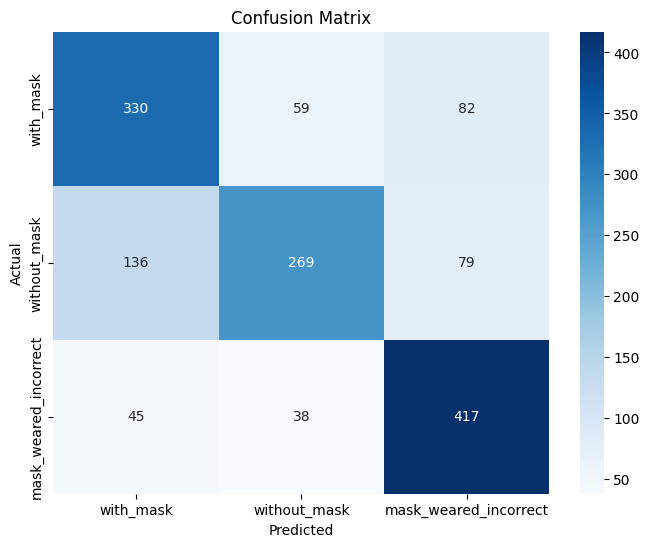

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = transfer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys()))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**6.7. Visualize Training and Validation Metrics**

Plot Accuracy and Loss

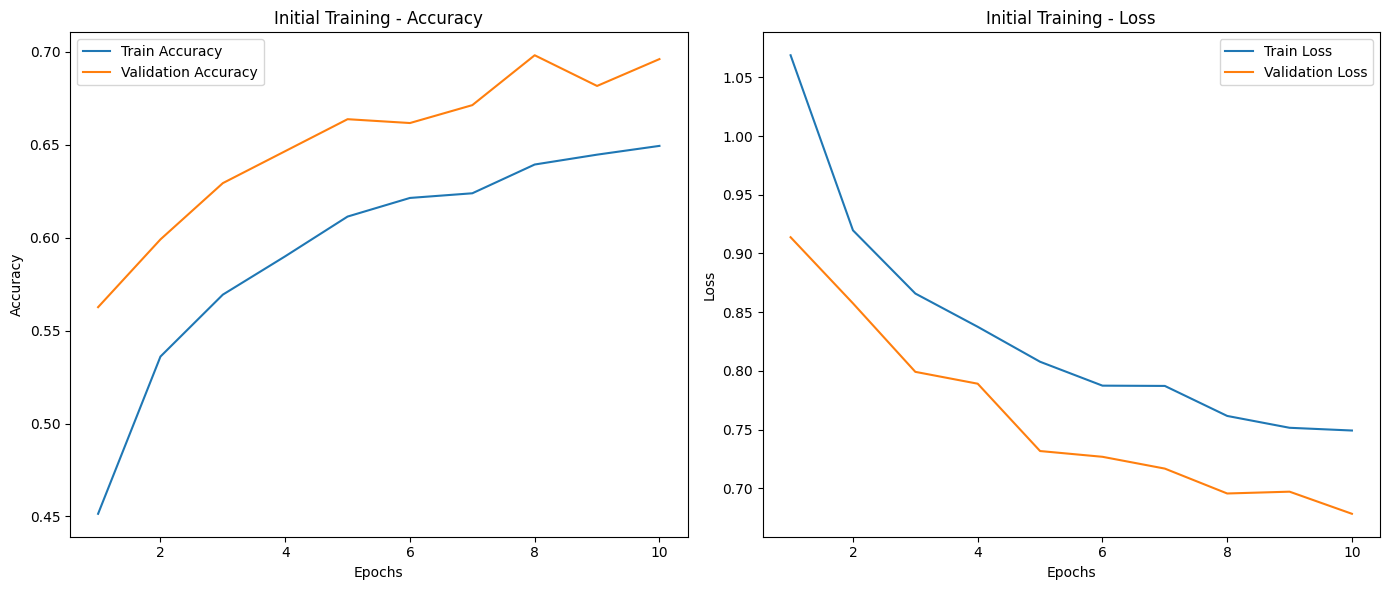

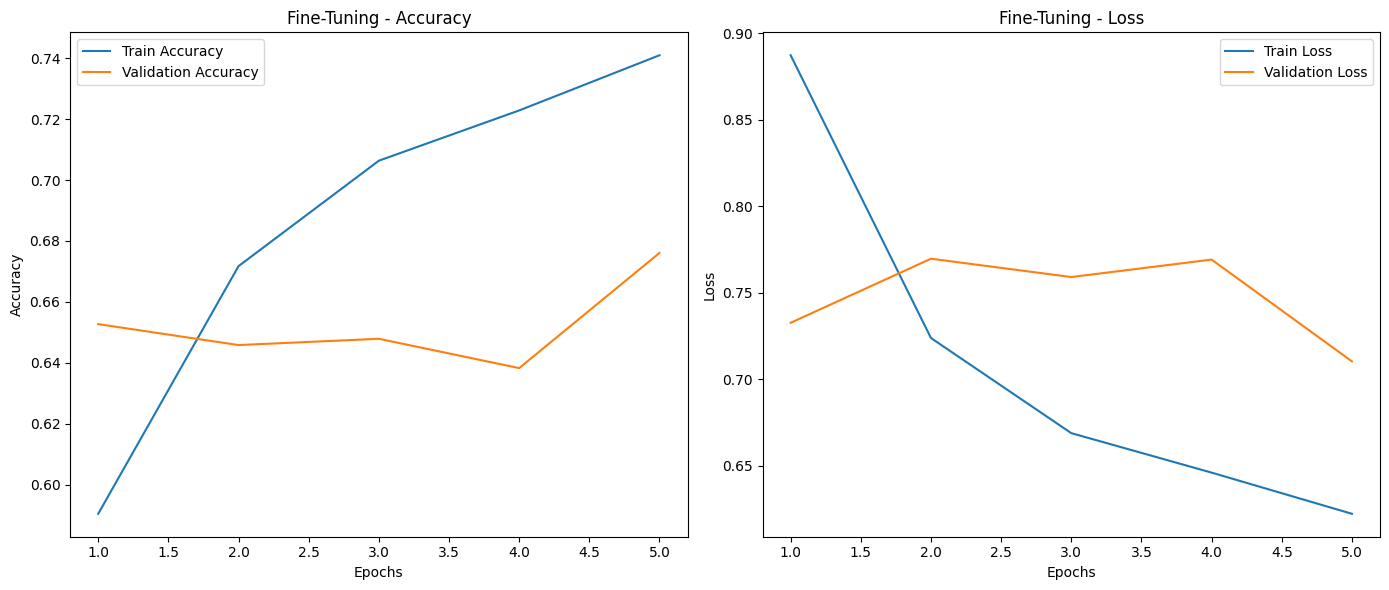

In [ ]:
# Function to plot training metrics
def plot_metrics(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot initial training metrics
plot_metrics(history, "Initial Training")

# Plot fine-tuning metrics
plot_metrics(history_fine_tune, "Fine-Tuning")


**Overall Metrics**

*  Accuracy:

  *  The overall percentage of correct predictions: 70%.
  *  Indicates that the model is correct in 70% of all predictions.

* Macro Average:

 *  The unweighted average of precision, recall, and F1-score across all classes.
 *  Treats all classes equally, regardless of support.
 *  Example: Precision, recall, and F1-score for the macro average are all 70%, showing consistent performance across classes.

* Weighted Average:

 *  The average of precision, recall, and F1-score, weighted by the number of samples in each class (support).

 *  Accounts for class imbalance.
 *  Example: The weighted average is 70%, similar to the macro average, as the dataset is relatively balanced after preprocessing.

**Class-Specific Insights**

**"with_mask":**

* Precision: 65% (moderate; some false positives).
* Recall: 70% (better; most "with_mask" samples are correctly identified).
* F1-score: 67% (balanced but has room for improvement).

**"without_mask":**

* Precision: 73% (better; fewer false positives).
* Recall: 56% (lower; many "without_mask" samples are missed).
* F1-score: 63% (affected by low recall).


**"mask_weared_incorrect":**

* Precision: 72% (good; relatively fewer false positives).
* Recall: 83% (excellent; most samples are correctly identified).
* F1-score: 77% (highest among all classes, indicating strong performance).

**Overall Interpretation**

*  **Strengths:**

The model performs best on the "mask_weared_incorrect" class, achieving a high F1-score of 77%.
Balanced performance across all classes, with macro and weighted averages around 70%.

*  **Weaknesses:**

Lower recall for "without_mask" indicates the model struggles to identify some "without_mask" samples.
Precision for "with_mask" could improve, as there are still some false positives.

## **Conclusion**

- **Use of Pre-Trained Model**:
  - We utilized a pre-trained model (e.g., MobileNetV2) as the base architecture for the face mask detection task.
  - Pre-trained models are trained on large datasets like ImageNet, allowing them to learn robust and generic feature representations.
  - Leveraging a pre-trained model significantly reduced the training time and computational cost compared to training a model from scratch.

- **Benefits of Transfer Learning**:
  - **Improved Performance**: Transfer learning allowed us to utilize well-learned features for tasks like edge detection, texture recognition, and pattern identification, which are crucial for identifying masks on faces.
  - **Reduced Data Dependency**: Using a pre-trained model made it possible to achieve high accuracy despite having a relatively smaller dataset.
  - **Faster Convergence**: The network required fewer epochs to converge, saving time and resources.

- **Project Outcomes**:
  - The use of a pre-trained model ensured high accuracy in detecting masks, achieving results that met project objectives.
  - Transfer learning proved to be an effective strategy for solving the problem with limited resources while maintaining excellent performance metrics.
